In [1]:
# To do:
# import the new data (which you dont have right now)
# This code is copied from my worksttion and the data are also there. So if you want to run this, you need to import those data as well.

In [2]:
import sys
sys.path.append('/central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src')  # For pyqdyn
import matplotlib.pyplot as plt
import numpy as np
from pyqdyn import qdyn
import ProcessFunctions
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from ProcessFunctions import FindMw


In [3]:
figsize = (9, 8)
def slip_profile(ox, warm_up=0, orientation="horizontal"):
    x_unique = ox["x"].unique()
    sort_inds = np.argsort(x_unique)
    x_unique = x_unique[sort_inds]
    t_vals = np.sort(ox["t"].unique())

    if warm_up > t_vals.max():
        print("Warm-up time > simulation time!")
        return

    ind_warmup = np.where(t_vals >= warm_up)[0][0]

    Nx = len(x_unique)
    Nt = len(t_vals) - 1

    slice = np.s_[Nx * ind_warmup:Nx * Nt]
    data_shape = (Nt - ind_warmup, Nx)
    x = ox["x"][slice].values.reshape(data_shape)[:, sort_inds]
    slip = ox["slip"][slice].values.reshape(data_shape)[:, sort_inds]
    v = ox["v"][slice].values.reshape(data_shape)[:, sort_inds]

    slip -= slip[0]
    t = t_vals[ind_warmup:-1]
    t -= t[0]

    fig = plt.figure(figsize=figsize)

    if orientation == "horizontal":
        CS = plt.contourf(x, slip, np.log10(v), levels=200, cmap="magma")
        plt.xlabel("position [m]")
        plt.ylabel("slip [m]")
        CB = plt.colorbar(CS, orientation="horizontal")
        CB.ax.set_title("slip rate [m/s]")
    elif orientation == "vertical":
        x -= x.min()
        CS = plt.contourf(slip, x * 1e-3, np.log10(v), levels=200, cmap="magma")
        plt.ylabel("depth [km]")
        plt.xlabel("slip [m]")
        plt.gca().invert_yaxis()
        CB = plt.colorbar(CS, orientation="horizontal")
        CB.ax.set_title("slip rate [m/s]")
    else:
        print("Keyword 'orientation=%s' not recognised" % orientation)
        plt.close()
        return
    plt.tight_layout()
    plt.show()

In [4]:
T_final = 3500
Ntout= 300
drs=0.006
t_yr = 3600 * 24 * 365.25   # seconds per 
L=240e3


In [22]:
# loading qdyn simulations
direct='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/2DSim_MainSimulation_Tf'+str(T_final)+"Nt="+str(Ntout)+"drs"+str(drs)+".npz"
data=np.load(direct)

In [33]:
v=data["v"]
#theta=p.ox["theta"]
#tau=p.ox["tau"]
slip=data["slip"]
t=data["t"]
a=data["a"]
Nx=int(a.shape[0]//2)


In [34]:
t.shape[0]/Nx

33971.0

In [35]:
T_filter=200
v_thresh=1e-2
T_filter_upbound=800
freq_plt_interevent=3*t_yr
freq_plt_event=3
# import slip

#x_ox=p.ox["x"].unique() # Centering
x_ox=np.linspace(-L/2,L/2,Nx)
#   Nx=len(x_ox)
Nt=int(t.shape[0]/Nx)

# remove first T_filter years from V_ox, slip and t
t=t.reshape((Nt,len(x_ox)))
t=t[:,0]
index=np.argmin(np.abs(t-T_filter*t_yr))
index_upbound=np.argmin(np.abs(t-T_filter_upbound*t_yr))
t=t[index:index_upbound]
V_ox=v.reshape((Nt,len(x_ox)))
V_ox=V_ox[index:index_upbound,:]
vmax=np.max(V_ox,axis=1)
slip=slip.reshape((Nt,len(x_ox)))
slip=slip[index:index_upbound,:]

interpolator = interp1d(t, slip, axis=0, kind='linear', fill_value='extrapolate')
flag=0
#   Mw=np.array([])
T1=np.array([]) # it is the time of when the earthquakes start
T2=np.array([]) # it is the time of when the earthquake stops
index_T1=np.array([])
index_T2=np.array([])
    # fig=plt.figure()
    
for i in range(vmax.size):
    if flag==0 and vmax[i]>v_thresh:
        flag=1
        index1=i
        
            # ax.axvline(Time[i]/t_yr,linestyle='dotted',color='black') 
        T1=np.append(T1,t[i])
        index_T1=np.append(index_T1,i)
    if flag==1 and vmax[i]<v_thresh:
        flag=0
        index2=i
        #IntPotRate=integrate.cumtrapz(PotRate[index1:index2+1],Time[index1:index2+1])
        #Integration=IntPotRate[-1]
        #M0=Integration*mu
        #Mw=np.append(Mw,(2/3)*math.log10(M0)-6)
        T2=np.append(T2,t[i])
        index_T2=np.append(index_T2,i)
        
slip_start=interpolator(T1)
slip_end=interpolator(T2)

# specifying the font and font size for the figures
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
# specefing figure size
# specifying the height ratio in the figure
L1VS = 40
LVW  = 72.5
L2VS = 15
Total=  L1VS*2 + LVW*2 + L2VS
height_ratio = [.5, 1]
width_ratio=[1,.8]

figsize = (3.7, 7)
# Create figure
fig = plt.figure(figsize=figsize)

# Create GridSpec with 2 rows and 2 columns to control width and height ratios
gs = GridSpec(2, 3, figure=fig, width_ratios=[.35, 1,.35], height_ratios=[.5, 1])

ax1 = fig.add_subplot(gs[0, :])  # First subplot, first row, first column
ax2 = fig.add_subplot(gs[1, 1])  # Second subplot, second row, first column
ax=[ax1,ax2]


#ax.add_patch(plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.5))
ax[0].add_patch(plt.Rectangle((0, 0), 1, 1, alpha=1,edgecolor='black',facecolor='none',linewidth=2,linestyle='--')) 
ax[0].add_patch(plt.Rectangle((L1VS/Total, 0), LVW/Total, 1,edgecolor='black',facecolor='black',alpha=0.2)) 
ax[0].add_patch(plt.Rectangle(((L1VS+LVW+L2VS)/Total, 0), LVW/Total, 1,edgecolor='black',facecolor='black',alpha=0.2)) 

#ax[0].set_xlim([-.1, 1.1])
#ax[0].set_ylim([-.1, 1.1])
# removing x and y axis from the plot
# wrting text on the plot, rotate the text by 90 degree
ax[0].text(L1VS/Total/2, 0.5, r'$a-b=0.02$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((L1VS+LVW/2)/Total, 0.5, r'$a-b=- 0.005$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text(0.5, 0.5, r'$a-b=0.002$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((L1VS+LVW+L2VS+LVW/2)/Total, 0.5, r'$a-b=- 0.005$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((Total-L1VS/2)/Total, 0.5, r'$a-b=0.02$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text(L1VS/Total/2, 1.1, r'$L_{1VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text((L1VS+LVW/2)/Total, 1.1, r'$L_{VW}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='red')
ax[0].text(0.5, 1.1, r'$L_{2VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text((L1VS+LVW+L2VS+LVW/2)/Total, 1.1, r'$L_{VW}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='red')
ax[0].text((Total-L1VS/2)/Total, 1.1, r'$L_{1VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')

# plot a horizental line 
ax[0].plot([0,L1VS/Total], [1,1], color='blue', linewidth=3,linestyle='--')
ax[0].plot([L1VS/Total,(L1VS+LVW)/Total], [1,1], color='red', linewidth=3,linestyle='--')
ax[0].plot([(L1VS+LVW)/Total,(L1VS+LVW+L2VS)/Total], [1,1], color='blue', linewidth=3,linestyle='--')
ax[0].plot([(L1VS+LVW+L2VS)/Total,(Total-L1VS)/Total], [1,1], color='red', linewidth=3,linestyle='--')
ax[0].plot([(Total-L1VS)/Total,1], [1,1], color='blue', linewidth=3,linestyle='--')

ax[0].plot([1,1+L1VS/Total], [1,1], color='black', linewidth=3)
ax[0].plot([1,1+L1VS/Total], [0,0], color='black', linewidth=3)
ax[0].plot([0,0-L1VS/Total], [0,0], color='black', linewidth=3)
ax[0].plot([0,0-L1VS/Total], [1,1], color='black', linewidth=3)
ax[0].plot([1+L1VS/Total,1+2*L1VS/Total], [1,1], color='black', linewidth=3,linestyle=':')
ax[0].plot([1+L1VS/Total,1+2*L1VS/Total], [0,0], color='black', linewidth=3,linestyle=':')
ax[0].plot([-L1VS/Total,0-2*L1VS/Total], [0,0], color='black', linewidth=3,linestyle=':')
ax[0].plot([-L1VS/Total,0-2*L1VS/Total], [1,1], color='black', linewidth=3,linestyle=':')
uu=0
vv=0.2
ax[0].quiver([1+(4/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([1+(2/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([1+(4/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([1+(2/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)

ax[0].quiver([-(4/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([-(2/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([-(4/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([-(2/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)

ax[0].text((Total+L1VS)/Total, .5, r'$v_{pl}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='black')
ax[0].text((0-L1VS)/Total, .5, r'$v_{pl}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='black')




ax[0].axis('off')

for i in range(T1.shape[0]-1): # not including everythin after the last event
    T_interevnt=np.arange(T2[i],T1[i+1],freq_plt_interevent) # from the end of the last event to the start of the next event
    T_event=np.arange(T1[i],T2[i],freq_plt_event) # from the start of the event to the end

    slip_interpolated_interevent = interpolator(T_interevnt)
    slip_interpolated_event=interpolator(T_event)

    for j in range(slip_interpolated_interevent.shape[0]):
        ax[1].plot(x_ox,slip_interpolated_interevent[j,:],color='b')
    for j in range(slip_interpolated_event.shape[0]):
        ax[1].plot(x_ox,slip_interpolated_event[j,:],color='r')

for j in range(slip_start.shape[0]):
    print(j)
    ax[1].plot(x_ox,slip_start[j,:],color='black')

for j in range(slip_end.shape[0]):
    ax[1].plot(x_ox,slip_end[j,:],color='black')

ax[1].set_xlabel('Distance along strike')
ax[1].set_ylabel('Cumulative slip (m)')
ax[1].set_xlim([x_ox[0],x_ox[-1]])

ax[1].set_xticks([])
ax[1].set_ylim(top=45,bottom=15)




# save figure
plt.savefig("/central/groups/astuart/hkaveh/Figs/ROM/Geom2D_andSim.png", format='png', dpi=300)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


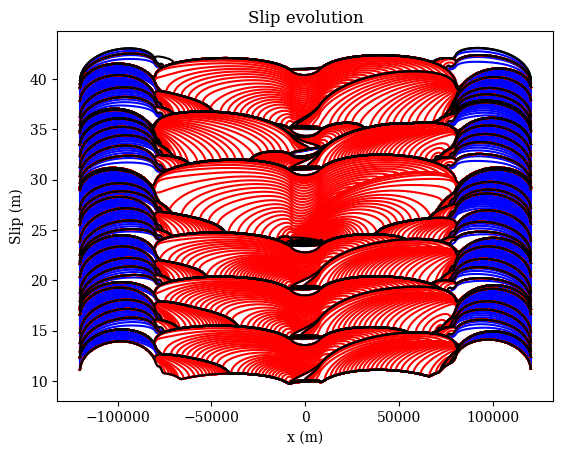

In [ ]:

for i in range(T1.shape[0]-1): # not including everythin after the last event
    T_interevnt=np.arange(T2[i],T1[i+1],freq_plt_interevent) # from the end of the last event to the start of the next event
    T_event=np.arange(T1[i],T2[i],freq_plt_event) # from the start of the event to the end

    slip_interpolated_interevent = interpolator(T_interevnt)
    slip_interpolated_event=interpolator(T_event)

    for j in range(slip_interpolated_interevent.shape[0]):
        plt.plot(x_ox,slip_interpolated_interevent[j,:],color='b')
        plt.title('Slip evolution')
        plt.xlabel('x (m)')
        plt.ylabel('Slip (m)')
    for j in range(slip_interpolated_event.shape[0]):
        plt.plot(x_ox,slip_interpolated_event[j,:],color='r')
        plt.title('Slip evolution')
        plt.xlabel('x (m)')
        plt.ylabel('Slip (m)')
for j in range(slip_start.shape[0]):
    print(j)
    plt.plot(x_ox,slip_start[j,:],color='black')
    plt.title('Slip evolution')
    plt.xlabel('x (m)')
    plt.ylabel('Slip (m)')
for j in range(slip_end.shape[0]):
    plt.plot(x_ox,slip_end[j,:],color='black')
    plt.title('Slip evolution')
    plt.xlabel('x (m)')
    plt.ylabel('Slip (m)')